In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import yfinance as yf

In [58]:
# Download stock data
ticker = 'WMT'
stock_data = yf.download(ticker)
stock_data.to_csv('/content/stock_data.csv')

# Load data
data = pd.read_csv('/content/stock_data.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
values = data['Close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X,y = create_sequences(scaled_values, seq_length)

[*********************100%%**********************]  1 of 1 completed


In [59]:
X_test=X[-30:]
y_test=y[-30:]

In [60]:
X_train=X[:-30]
y_train=y[:-30]

In [61]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [62]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
history=model.fit(X_train, y_train, batch_size=1, epochs=10)


Epoch 1/10
12977/12977 [==============================] - 205s 16ms/step - loss: 2.9579e-04
Epoch 2/10
12977/12977 [==============================] - 215s 17ms/step - loss: 1.0739e-04
Epoch 3/10
12977/12977 [==============================] - 222s 17ms/step - loss: 8.0162e-05
Epoch 4/10
12977/12977 [==============================] - 224s 17ms/step - loss: 6.9711e-05
Epoch 5/10
12977/12977 [==============================] - 215s 17ms/step - loss: 6.5886e-05
Epoch 6/10
12977/12977 [==============================] - 204s 16ms/step - loss: 5.9024e-05
Epoch 7/10
12977/12977 [==============================] - 210s 16ms/step - loss: 5.4270e-05
Epoch 8/10
12977/12977 [==============================] - 204s 16ms/step - loss: 5.1171e-05
Epoch 9/10
12977/12977 [==============================] - 213s 16ms/step - loss: 4.9546e-05
Epoch 10/10
12977/12977 [==============================] - 204s 16ms/step - loss: 4.9899e-05


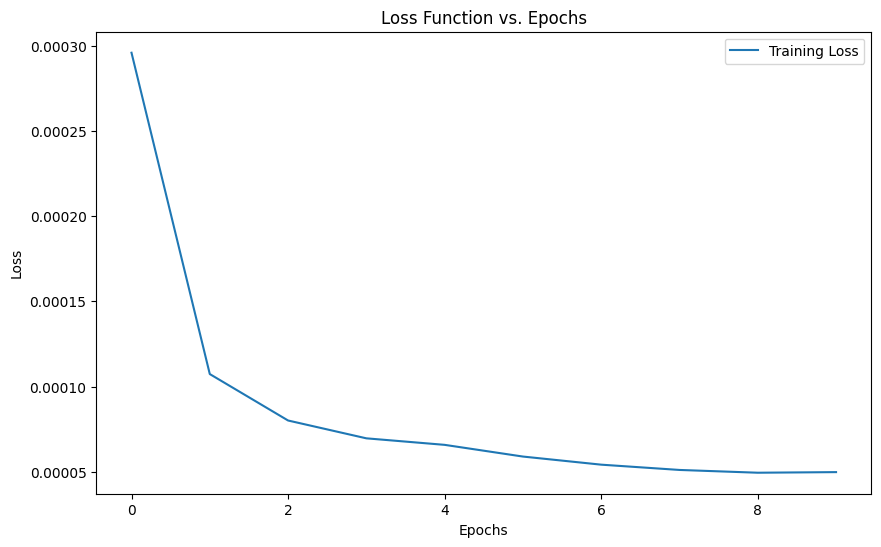

In [64]:
# Plot of Loss Functions against the Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Function vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

train = data[:len(X_train) + seq_length]
valid = data[len(X_train) + seq_length:]
valid['Predictions'] = predictions


# Comparing the Actual and Predicted Data
valid['Predictions'].compare(data['Close'].tail(30))

1/1 [==============================] - 0s 35ms/step


<ipython-input-67-bf5fcbd81706>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,self,other
Date,,
2024-05-10,60.816486,60.480000
2024-05-13,60.846832,60.410000
2024-05-14,60.798767,59.860001
2024-05-15,60.294353,59.830002
2024-05-16,60.225292,64.010002
2024-05-17,63.936813,64.650002
2024-05-20,64.759659,64.180000
2024-05-21,64.658279,65.150002
2024-05-22,65.547523,65.250000


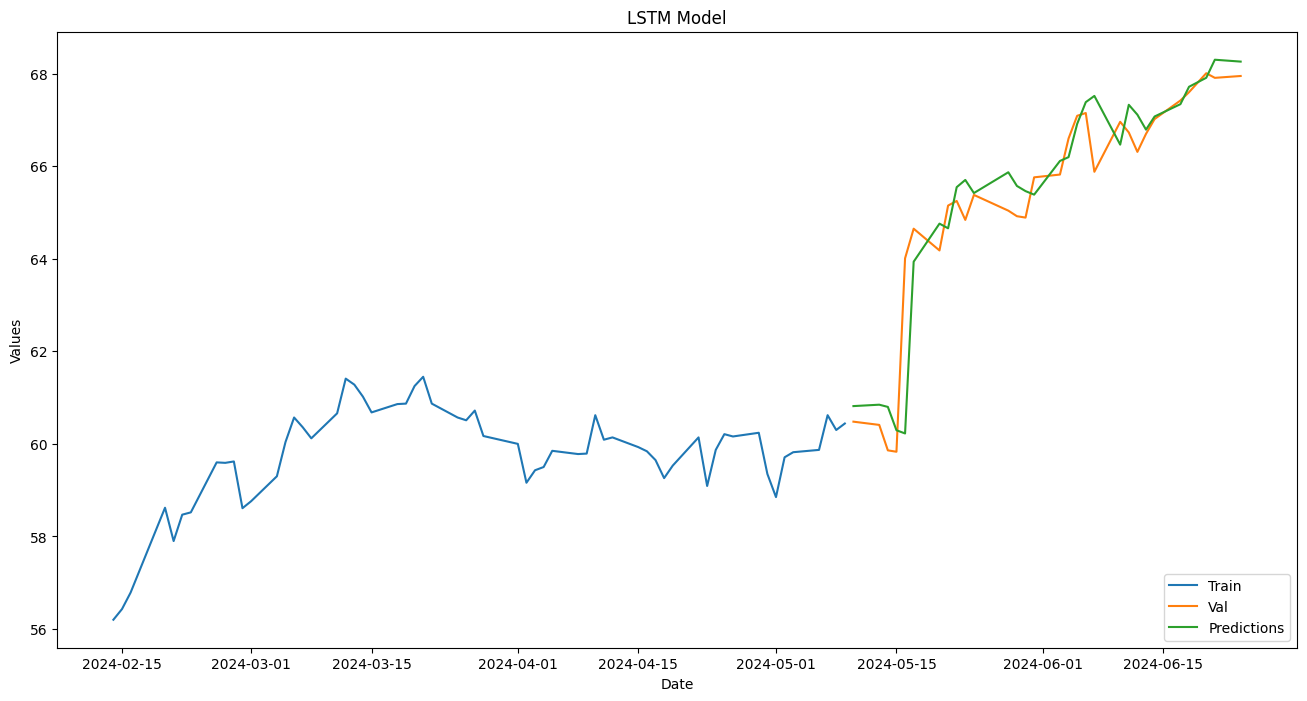

In [68]:
# Visualize the predictions
plt.figure(figsize=(16, 8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Values')
plt.plot(train.tail(60)['Close'])
plt.plot(valid.tail(60)[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()